# Samples analysis
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hsimonfroy/benchmark-field-level/blob/main/examples/sample_analysis.ipynb)

Analyse cosmological model posterior samples.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)
print(jdevices())

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload, Path
from getdist import plots

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname

save_dir = Path("/feynman/home/dphp/hs276503/scratch/png/lpt_64_fnl_m50")
save_path = save_dir / "test"
save_dir.mkdir(parents=True, exist_ok=True)

[cuda(id=0)]
feynmangpu01.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Example 1: assess MCMC convergence

In [2]:
from montecosmo.chains import Chains
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh, theme, SetDark2
theme(usetex=True, font_size=12)

# Load chain files, which are just dictionaries of arrays, saved with jnp.savez
model = FieldLevelModel.load(save_dir / "model.yaml")

truth = dict(jnp.load(save_dir / 'truth.npz'))
mesh_true = jnp.fft.irfftn(truth['init_mesh'])
kpow_true = model.spectrum(mesh_true)
count_obs = model.masked2mesh(truth['obs'])
delta_obs = model.count2delta(count_obs)
kptc_obs = model.powtranscoh(mesh_true, delta_obs)

obs = ['obs','Omega_m','sigma8','b1','b2','bs2','bn2','fNL','ngbar','init_mesh']
obs = {k: truth[k] for k in obs}
model.condition(obs, from_base=True)

transforms = [
            #   lambda x: x[:3],
              partial(Chains.thin, thinning=1),                     # thin the chains
              model.reparam_chains,                                 # reparametrize sample variables into base variables
              partial(model.powtranscoh_chains, mesh0=mesh_true),   # compute mesh statistics
              partial(Chains.choice, n=10, names=['init','init_']), # subsample mesh 
              ]
chains = model.load_runs(save_path, 1, 15, transforms=transforms, batch_ndim=2)
names = ['cosmo','bias','syst','init']
# names = ['cosmo_','bias_','syst_','init_']
chains.shape

2025-05-19 08:38:45.457725: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Loading: test, from run 1 to run 15 (included)


{'Omega_m': (4, 1920),
 'b1': (4, 1920),
 'b2': (4, 1920),
 'bn2': (4, 1920),
 'bs2': (4, 1920),
 'fNL': (4, 1920),
 'init_mesh': (4, 1920, 10),
 'kptc': ((4, 1920, 12), (4, 1920, 12), (4, 1920, 12), (4, 1920, 12)),
 'logdensity': (4, 1920),
 'mse_per_dim': (4, 1920),
 'n_evals': (4, 1920),
 'ngbar': (4, 1920),
 'sigma8': (4, 1920)}

### Inspecting chains
We look for mixed chains (no visible trends), `n_eff`>500, `r_hat`<1.01

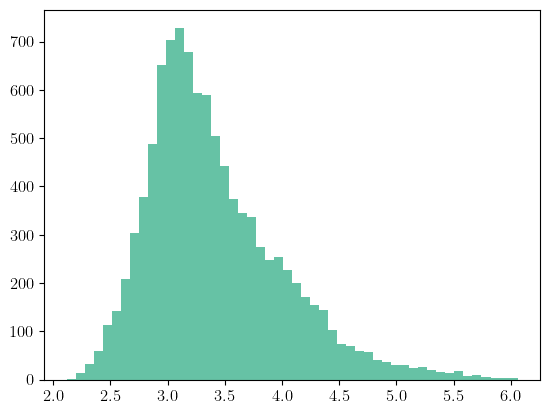

In [3]:
plt.hist(chains['init_mesh_'].std((0,1)), bins=50);

ss:  [4.38302881 4.38302881 4.38302881 4.38302881]
L:  [876.60576262 876.60576262 876.60576262 876.60576262]
inv_mm: {'Omega_m_': Array(0.32774176, dtype=float64), 'b1_': Array(2.92098985, dtype=float64), 'b2_': Array(12.19249034, dtype=float64), 'bn2_': Array(49.37735799, dtype=float64), 'bs2_': Array(10.99289079, dtype=float64), 'fNL_': Array(0.89007327, dtype=float64), 'init_mesh_': Array([[[ 1.07680212,  3.31145509,  8.73309103, ...,  7.75469432,
          8.3818326 ,  7.57725579],
        [ 1.24484397,  3.95179685,  8.88977582, ...,  9.03220362,
          7.36048963,  7.54534025],
        [ 3.72282862,  6.21981313, 13.54450372, ..., 10.63679783,
          6.66514583,  9.77037669],
        ...,
        [ 9.37699086,  5.94149245,  7.99174793, ..., 10.2226363 ,
          8.73806211,  6.5273992 ],
        [ 7.00878961,  5.18494728,  8.80462956, ..., 10.63847223,
          6.36424574,  8.43943762],
        [ 8.53008178,  5.40213843,  9.40003063, ...,  9.25434624,
          7.81848644, 

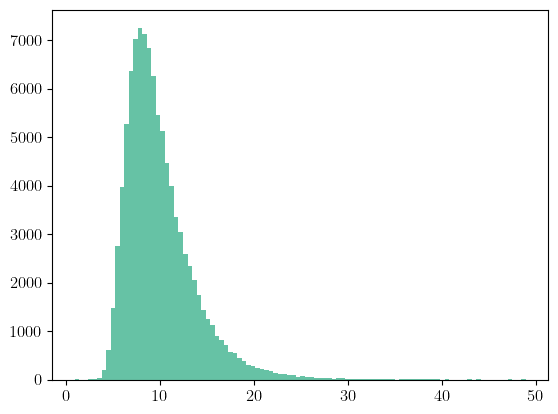

In [4]:
config = pload(save_path+"_conf.p")
state = pload(save_path+"_last_state.p")

print("ss: ", config.step_size)
print("L: ", config.L)
from jax.flatten_util import ravel_pytree
flat, unrav_fn = ravel_pytree(tree.map(lambda x:x[0], state.position))
print("inv_mm:", unrav_fn(config.inverse_mass_matrix[0]))

plt.hist(np.random.choice(config.inverse_mass_matrix[0], 100_000), bins=100);

In [4]:
chains.groups['bias'].remove('fNL')


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      Omega_m      0.30      0.00      0.30      0.30      0.30    671.96      1.00
   logdensity -946712.13    395.87 -946712.60 -947343.33 -946028.55   2296.95      1.00
        ngbar      0.00      0.00      0.00      0.00      0.00    497.35      1.00
          fNL    -49.80     13.91    -49.20    -72.93    -27.81    663.10      1.01
          bs2     -0.08      0.09     -0.08     -0.22      0.07    642.72      1.00
      n_evals    128.00      0.00    128.00    128.00    128.00       nan       nan
  mse_per_dim      0.00      0.00      0.00      0.00      0.00   1969.15      1.00
 init_mesh[0]     -0.10      0.12     -0.10     -0.29      0.11   2826.70      1.00
 init_mesh[1]     -0.02      0.31     -0.01     -0.55      0.46   1395.50      1.00
 init_mesh[2]      0.03      0.30      0.03     -0.46      0.52   1429.38      1.00
 init_mesh[3]     -0.00      0.30     -0.00     -0.48      0.50   1424.

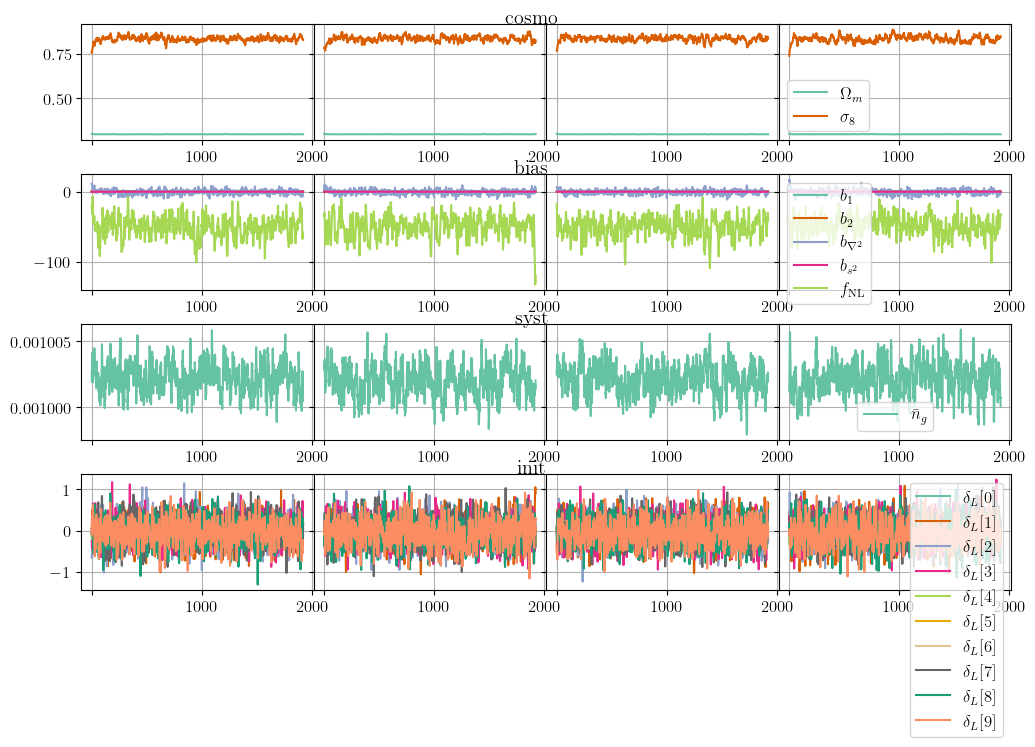

In [3]:
plt.figure(figsize=(12,6))
chains[['*~kptc']].flatten().plot(names)
chains[['*~kptc']].print_summary()

Removed no burn in


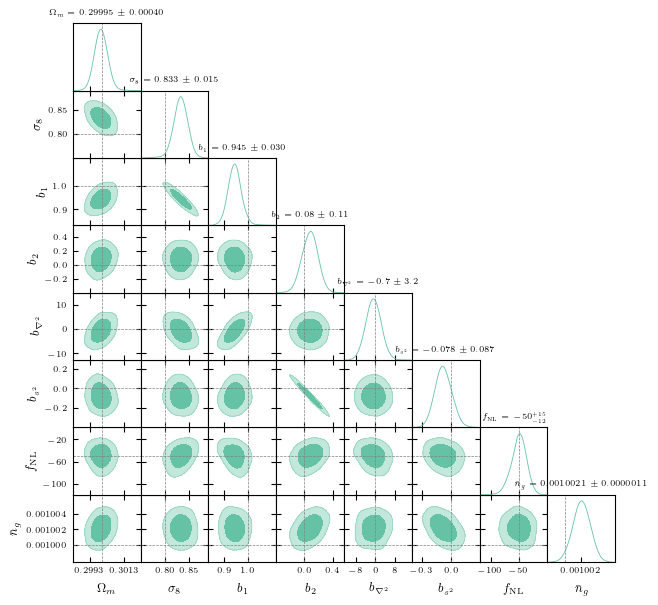

In [5]:
gdsamp = chains[names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

### Inspection at the field-Level
Power spectrum should converge close to the truth, and coherence must be on the order of the coherence between truth and obs

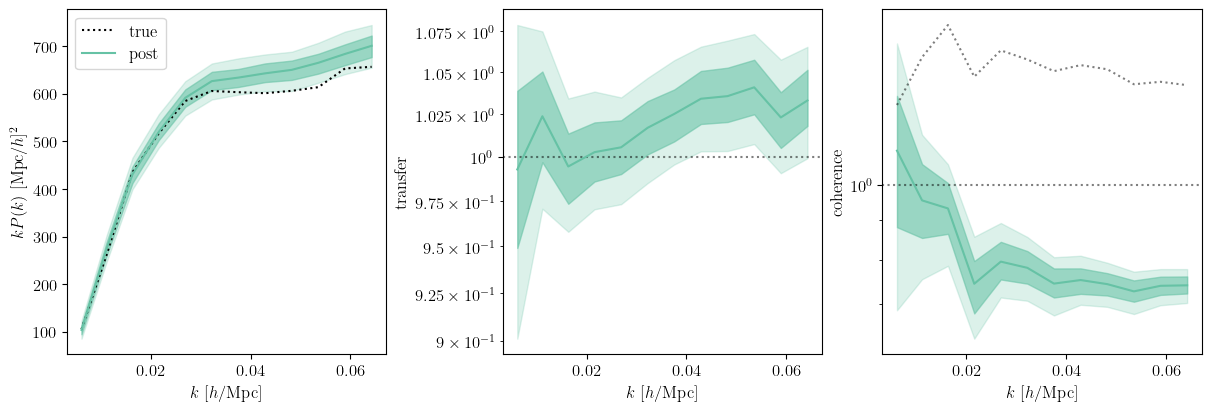

In [ ]:
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh, theme, SetDark2

prob = 0.95
plt.figure(figsize=(12, 4), layout='constrained')
def plot_kptcs(kptcs, label=None):
    plot_powtranscoh(*kptcs, fill=0.68, color=SetDark2(0))
    plot_powtranscoh(*kptcs, fill=0.95, color=SetDark2(0))
    plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptcs), label=label)

plt.subplot(131)
plot_pow(*kpow_true, 'k:', label='true')
plt.subplot(132)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_obs[0], kptc_obs[3], 'k:', alpha=0.5, label='obs')

kptcs = tree.map(jnp.concatenate, chains['kptc'])
plot_kptcs(kptcs, label='post')
plt.subplot(131)
plt.legend();
# plt.savefig(f'init_warm.png')   

In [9]:
from montecosmo.chains import Chains
from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh, theme, SetDark2
theme(usetex=True, font_size=12)

# Load chain files, which are just dictionaries of arrays, saved with jnp.savez
model = FieldLevelModel.load(save_dir / "model.yaml")

truth = dict(jnp.load(save_dir / 'truth.npz'))
mesh_true = jnp.fft.irfftn(truth['init_mesh'])
kpow_true = model.spectrum(mesh_true)
count_obs = model.masked2mesh(truth['obs'])
delta_obs = model.count2delta(count_obs)
kptc_obs = model.powtranscoh(mesh_true, delta_obs)

obs = ['obs','Omega_m','sigma8','b1','b2','bs2','bn2','fNL','ngbar','init_mesh']
obs = {k: truth[k] for k in obs}
model.condition(obs, from_base=True)

transforms = [
            #   lambda x: x[:3],
              partial(Chains.thin, thinning=100),
              model.reparam_chains,
              partial(model.powtranscoh_chains, mesh0=mesh_true),
              ]
chains = model.load_runs(save_path, 1, 100, transforms=transforms, batch_ndim=2)
chains.shape

Loading: test, from run 1 to run 100 (included)
File /feynman/home/dphp/hs276503/scratch/png/lpt_fnl_64/test_14.npz does not exist, stopping at run 13


{'Omega_m': (4, 13),
 'b1': (4, 13),
 'b2': (4, 13),
 'bn2': (4, 13),
 'bs2': (4, 13),
 'fNL': (4, 13),
 'init_mesh': (4, 13, 52, 102, 50),
 'kptc': ((4, 13, 12), (4, 13, 12), (4, 13, 12), (4, 13, 12)),
 'logdensity': (4, 13),
 'mse_per_dim': (4, 13),
 'n_evals': (4, 13),
 'ngbar': (4, 13),
 'sigma8': (4, 13)}

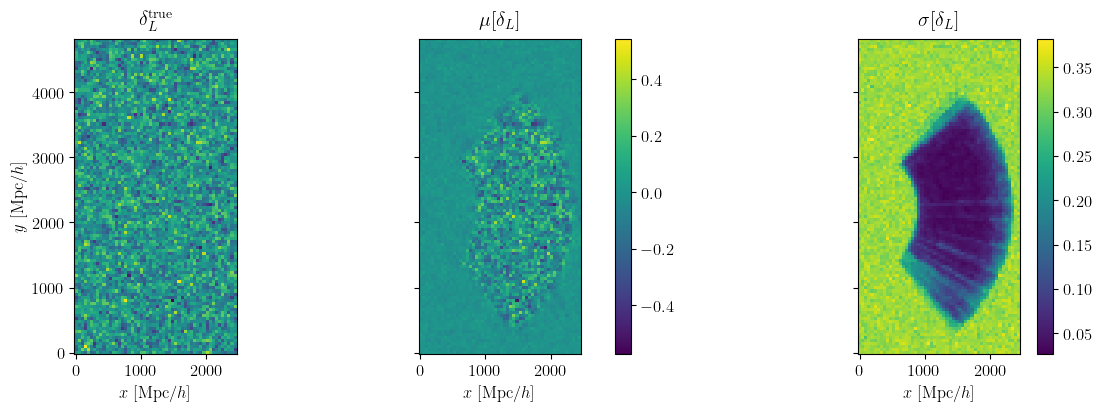

In [13]:
from montecosmo.plot import plot_mesh

axis = 2
ind = .1
meshes = jnp.concatenate(chains['init'])

plt.figure(figsize=(12, 4), layout='constrained')
ax1 = plt.subplot(131)
plt.title('$\\delta_L^\\mathrm{true}$', pad=10)
quad1 = plot_mesh(mesh_true, model.box_shape, ind, axis)
clim = quad1.get_clim()

ax2 = plt.subplot(132, sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.title('$\\mu[\\delta_L]$', pad=10)
plot_mesh(meshes.mean(0), model.box_shape, ind, axis, vlim=clim)
plt.ylabel(None)
plt.colorbar(ax=np.array([ax1, ax2]))

ax3 = plt.subplot(133)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.title('$\\sigma[\\delta_L]$', pad=10)
plot_mesh(meshes.std(0), model.box_shape, ind, axis)
plt.ylabel(None)
plt.colorbar();

In [ ]:
import fitsio
from montecosmo.bricks import radecz2cart
from jax.scipy.spatial.transform import Rotation
import plotly.graph_objects as go


fits_path = Path("/home/nfs/bao/AbacusSummit_v4_2/mock0/LRG_complete_SGC_1_clustering.ran.fits")
data = fitsio.read(fits_path, columns=['RA','DEC','Z'])
pos = radecz2cart(model.cosmo_fid, data)
pos = pos[np.random.choice(len(pos), 10_000, replace=False)]
pos_mesh = model.pos_mesh().reshape(-1,3)
frac_zero = lambda x: float((0 - np.min(x)) / (np.max(x) - np.min(x)))
padding = 0.2

fig = go.Figure()
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    legend=dict(xanchor="right", x=0.99, yanchor="top", y=0.9,) 
    # width=800, height=800,
    )

fig.add_scatter3d(x=[0], y=[0], z=[0], marker=dict(size=5, color='red', symbol='cross'), name='origin')

fig.add_scatter3d(
    x=pos[...,0], 
    y=pos[...,1], 
    z=pos[...,2], 
    mode='markers',
    marker=dict(size=2, color='royalblue', symbol='circle'),
    opacity=0.5,
    name='randoms',
    showlegend=True,
    visible="legendonly",
    )

fig.add_volume(
    x=pos_mesh[...,0],
    y=pos_mesh[...,1],
    z=pos_mesh[...,2],
    value=delta_obs.flatten(),
    opacity=1.,
    surface_count=5,
    name='observation',
    colorscale= [[0., '#2166ac'], [frac_zero(delta_obs), 'rgba(255, 255, 255, 0)'], [1., '#b2182b']],
    showlegend=True,
    hoverinfo='skip',
  )

fig.add_volume(
    x=pos_mesh[...,0],
    y=pos_mesh[...,1],
    z=pos_mesh[...,2],
    value=model.wind_mesh.flatten(),
    opacity=0.5,
    surface_count=5,
    colorscale= [[0., 'rgba(255, 255, 255, 0)'], [1., 'black']],
    name='window',
    showlegend=True,
    showscale=False,
    visible="legendonly",
    hoverinfo='skip',
  )

def plot_box(center, rotvec, shape, name=None, color='blue'):
    rect = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                    [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]])
    rot = Rotation.from_rotvec(rotvec)
    rect = rot.apply(shape * (rect - .5)) + center

    edges = [(0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
            (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
            (0, 4), (1, 5), (2, 6), (3, 7)]  # Vertical edges

    showlegend = True
    for edge in edges:
        fig.add_scatter3d(
            x=rect[edge, 0],
            y=rect[edge, 1],
            z=rect[edge, 2],
            mode='lines',
            line=dict(color=color, dash='solid'),
            legendgroup=name,
            showlegend=showlegend,
            name=name+f": {shape.prod() / 1e9:.1f} [Gpc/h]^3",
            opacity=0.5,
        )
        showlegend = False

plot_box(model.box_center, model.box_rotvec, model.box_shape / (1 + padding), name="box", color='darkblue')
# plot_box(model.box_center, model.box_rotvec, model.box_shape / (1 + padding), name="Data Box", color='darkblue')
# plot_box(model.box_center, model.box_rotvec, model.box_shape, name="Simu Box", color='darkblue')
fig.show()
fig.write_html("field.html", include_plotlyjs='cdn')

In [ ]:
from jax.scipy.spatial.transform import Rotation
import plotly.graph_objects as go

pos_mesh = model.pos_mesh().reshape(-1,3)
frac_zero = lambda x: float((0 - np.min(x)) / (np.max(x) - np.min(x)))

fig = go.Figure()
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    legend=dict(xanchor="right", x=0.99, yanchor="top", y=0.9,) 
    # width=800, height=800,
    )

fig.add_scatter3d(x=[0], y=[0], z=[0], marker=dict(size=5, color='red', symbol='cross'), name='origin')

fig.add_volume(
    x=pos_mesh[...,0],
    y=pos_mesh[...,1],
    z=pos_mesh[...,2],
    value=meshes.mean(0).flatten(),
    opacity=1.,
    surface_count=5,
    name='mean',
    colorscale=[[0., '#2166ac'], [frac_zero(meshes.mean(0)), 'rgba(255, 255, 255, 0)'], [1., '#b2182b']],
    showlegend=True,
    # visible="legendonly",
    hoverinfo='skip',
    )

fig.add_volume(
    x=pos_mesh[...,0],
    y=pos_mesh[...,1],
    z=pos_mesh[...,2],
    value=meshes.std(0).flatten(),
    opacity=.1,
    surface_count=5,
    name='std',
    colorscale=[[0., 'blue'], [1., 'rgba(255, 255, 255, 0)']],
    showlegend=True,
    visible="legendonly",
    hoverinfo='skip',
    )

# fig.add_volume(
#     x=pos_mesh[...,0],
#     y=pos_mesh[...,1],
#     z=pos_mesh[...,2],
#     value=model.wind_mesh.flatten(),
#     opacity=0.5,
#     surface_count=5,
#     colorscale=[[0., 'rgba(255, 255, 255, 0)'], [1., 'black']],
#     name='window',
#     showlegend=True,
#     showscale=False,
#     visible="legendonly",
#     hoverinfo='skip',
#     )

def plot_box(center, rotvec, shape, name=None, color='blue'):
    rect = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                    [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]])
    rot = Rotation.from_rotvec(rotvec)
    rect = rot.apply(shape * (rect - .5)) + center

    edges = [(0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
            (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
            (0, 4), (1, 5), (2, 6), (3, 7)]  # Vertical edges

    showlegend = True
    for edge in edges:
        fig.add_scatter3d(
            x=rect[edge, 0],
            y=rect[edge, 1],
            z=rect[edge, 2],
            mode='lines',
            line=dict(color=color, dash='solid'),
            legendgroup=name,
            showlegend=showlegend,
            name=name+f": {shape.prod() / 1e9:.1f} [Gpc/h]^3",
            opacity=0.5,
        )
        showlegend = False

plot_box(model.box_center, model.box_rotvec, model.box_shape, name="box", color='darkblue')
fig.show()
# fig.write_html("field.html", include_plotlyjs='cdn')

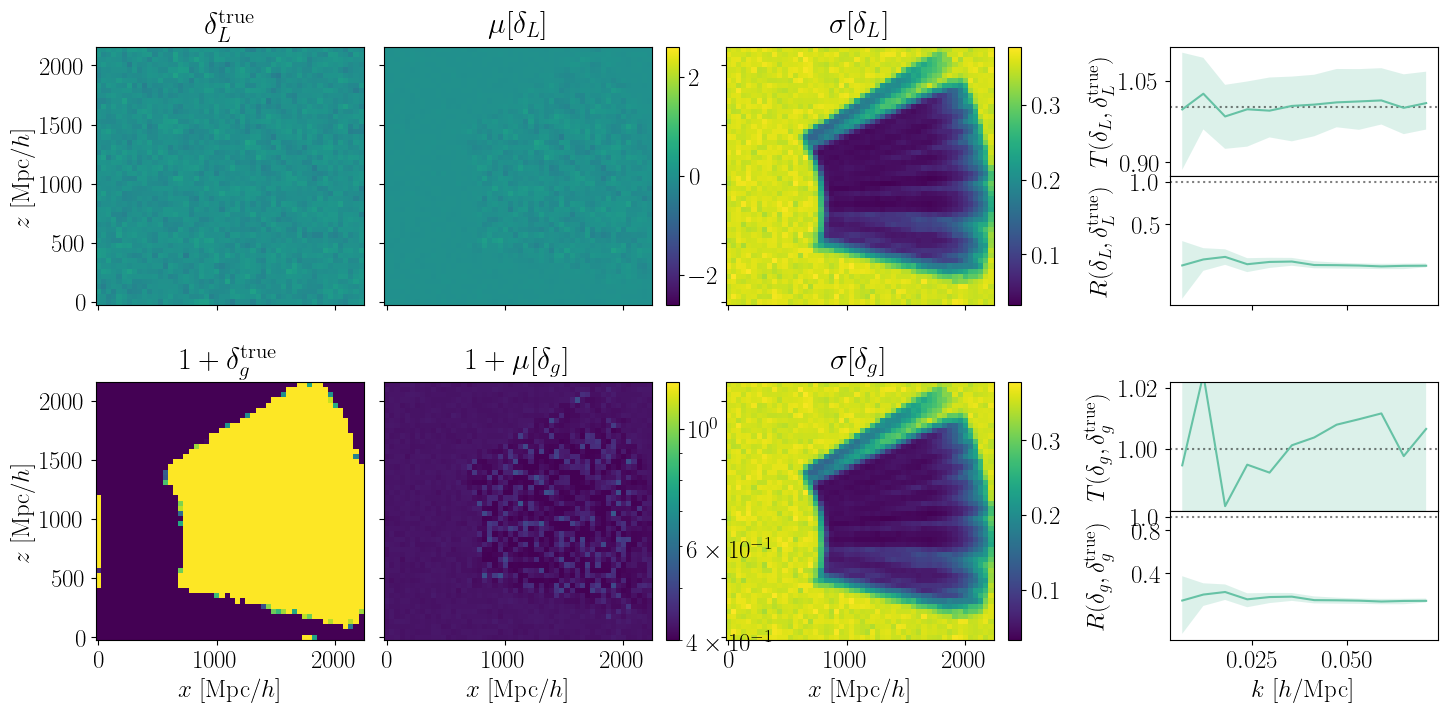

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
theme(usetex=True, font_size=18)

chlin = chains
chobs = chains

def scalarformatter(n):
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    if isinstance(n, int):
        plt.gca().yaxis.set_major_locator(mpl.ticker.MaxNLocator(n))
        plt.gca().yaxis.set_minor_locator(mpl.ticker.MaxNLocator(n))
    else:
        plt.gca().yaxis.set_major_locator(mpl.ticker.FixedLocator(n))
        plt.gca().yaxis.set_minor_locator(mpl.ticker.FixedLocator([]))
        

# Create a figure
fig = plt.figure(figsize=(18, 7.7))

gs14 = GridSpec(2, 4, figure=fig, wspace=0.4, hspace=0.3)
gs21_14 = gs14[0, 3].subgridspec(2, 1, hspace=0)
gs21_24 = gs14[1, 3].subgridspec(2, 1, hspace=0)

gs12_11 = gs14[0, 0:3].subgridspec(1, 3, wspace=-0.1)
gs12_21 = gs14[1, 0:3].subgridspec(1, 3, wspace=-0.1)

# Add subplots to the inner grid
ax141 = fig.add_subplot(gs21_14[0])
ax142 = fig.add_subplot(gs21_14[1], sharex=ax141)
plt.setp(ax141.get_xticklabels(), visible=False)
plt.setp(ax142.get_xticklabels(), visible=False)


ax241 = fig.add_subplot(gs21_24[0])
ax242 = fig.add_subplot(gs21_24[1], sharex=ax241)
plt.setp(ax241.get_xticklabels(), visible=False)

ax11 = fig.add_subplot(gs12_11[0])
plt.setp(ax11.get_xticklabels(), visible=False)
ax12 = fig.add_subplot(gs12_11[1], sharey=ax11)
plt.setp(ax12.get_yticklabels(), visible=False)
plt.setp(ax12.get_xticklabels(), visible=False)
# ax112.set_yticks([])
ax13 = fig.add_subplot(gs12_11[2], sharey=ax11)
plt.setp(ax13.get_yticklabels(), visible=False)
plt.setp(ax13.get_xticklabels(), visible=False)

ax21 = fig.add_subplot(gs12_21[0])
ax22 = fig.add_subplot(gs12_21[1], sharey=ax21)
plt.setp(ax22.get_yticklabels(), visible=False)
ax23 = fig.add_subplot(gs12_21[2], sharey=ax21)
plt.setp(ax23.get_yticklabels(), visible=False)




# Linear matter field
ids = 0.1
log = False
prob = 0.95
cmap = 'viridis'
axis = -2
meshes = jnp.concatenate(chlin['init'])

plt.sca(ax11)
lim = 2.6
plot_mesh(mesh_true, model.box_shape, ids, axis, vlim=(-lim, lim), cmap=cmap)
# plt.colorbar()
plt.xlabel(None)
plt.title('$ \\delta_L^\\mathrm{true}$', pad=10)

plt.sca(ax12)
plot_mesh(meshes.mean(0), model.box_shape, ids, axis, vlim=(-lim, lim), cmap=cmap)
plt.ylabel(None)
# plt.yticks([])
plt.xlabel(None)
plt.title('$\\mu[\\delta_L]$', pad=10)
plt.colorbar(ax=np.array([ax11, ax12]), pad=0.02, fraction=0.1)

plt.sca(ax13)
plot_mesh(meshes.std(0), model.box_shape, ids, axis, cmap=cmap)
plt.ylabel(None)
plt.xlabel(None)
plt.colorbar(pad=0.04)
plt.title('$\\sigma[\\delta_L]$', pad=10)

plt.sca(ax141)
kptcs = tree.map(jnp.concatenate, chlin['kptc'])
kptc_med = tree.map(lambda x: jnp.median(x, 0), kptcs)

plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_trans(kptc_med[0], kptc_med[2])
plot_trans(kptcs[0], kptcs[2], fill=prob)
plt.ylabel('$T(\\delta_L, \\delta_L^\\mathrm{true})$')
plt.xlabel(None)
scalarformatter(2)

plt.sca(ax142)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_med[0], kptc_med[3])
plot_coh(kptcs[0], kptcs[3], fill=prob)
plt.ylabel('$R(\\delta_L, \\delta_L^\\mathrm{true})$', labelpad=12)
scalarformatter([1.0, 0.5, 0.1])
plt.xlabel(None)


# Galaxy density field
ids = 0.1
log = False
prob = 0.95
# meshes = jnp.concatenate(chobs['obs'])
meshes = jnp.concatenate(chobs['init'])

vmin = 0.4
means = jnp.maximum(meshes, vmin).mean(0)
vmax = np.quantile(means, 1-1e-4/2)

plt.sca(ax21)
quad21 = plot_mesh(jnp.maximum(count_obs, vmin), model.box_shape, ids, axis, vlim=(vmin,vmax), cmap=cmap, norm='log')
plt.title('$1+ \\delta_g^\\mathrm{true}$', pad=10)
clim = quad21.get_clim()

plt.sca(ax22)
plot_mesh(means, model.box_shape, ids, axis, vlim=clim, cmap=cmap, norm='log')
plt.ylabel(None)
# plt.yticks([])
plt.title('$1+\\mu[\\delta_g]$', pad=10)
plt.colorbar(ax=np.array([ax21, ax22]), pad=0.02, fraction=0.1)

plt.sca(ax23)
plot_mesh(meshes.std(0), model.box_shape, ids, axis, cmap=cmap)
plt.ylabel(None)
plt.colorbar(pad=0.04)
plt.title('$\\sigma[\\delta_g]$', pad=10)

plt.sca(ax241)
kptcs = tree.map(jnp.concatenate, chobs['kptc'])
kptc_med = tree.map(lambda x: jnp.median(x, 0), kptcs)

plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_trans(kptc_med[0], kptc_med[2])
plot_trans(kptcs[0], kptcs[2], fill=prob)
plt.ylabel('$T(\\delta_g, \\delta_g^\\mathrm{true})$')
plt.xlabel(None)
plt.ylim(0.98, 1.022)
scalarformatter([1.0, 1.02])

plt.sca(ax242)
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plot_coh(kptc_med[0], kptc_med[3])
plot_coh(kptcs[0], kptcs[3], fill=prob)
plt.ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$', labelpad=12)
# ax242.yaxis.set_label_position("right")
# ax242.set_ylabel('$R(\\delta_g, \\delta_g^\\mathrm{true})$', rotation=270, labelpad=20)
scalarformatter([1.0, 0.8, 0.4])

# plt.savefig('post_fields4.png', dpi=500, bbox_inches='tight')
plt.show()

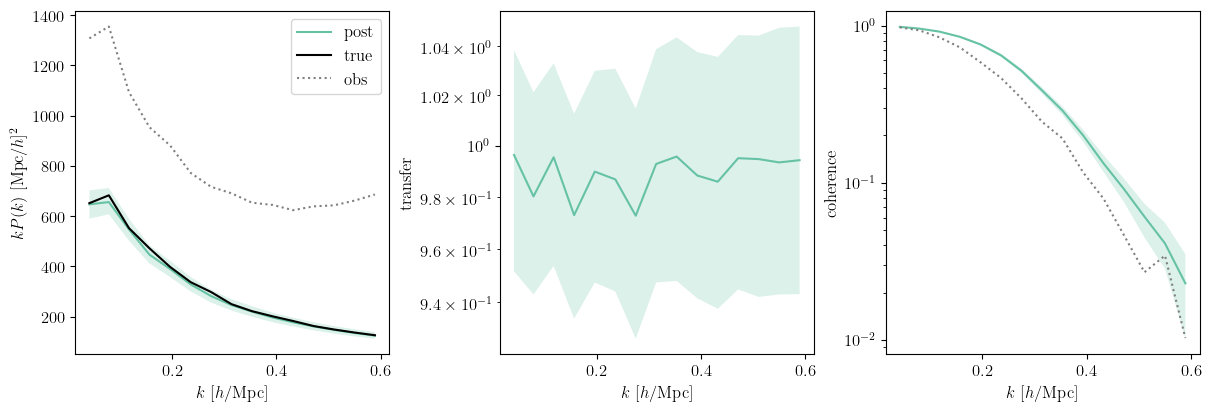

In [ ]:
prob = 0.95
log = False

plt.figure(figsize=(12, 4), layout="constrained")
kptc = tree.map(jnp.concatenate, chains['kptc'])
plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptc), log=log, label='post')
plot_powtranscoh(*kptc, log=log, fill=prob)

plt.subplot(131)
plot_pow(*kpow_true, 'k', log=log, label='true')
plot_pow(*kptc_obs[:2], ':', c='grey', log=log, label='obs')
plt.legend()

plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[-1], ':', log=log, c='grey', label='obs')

Removed no burn in


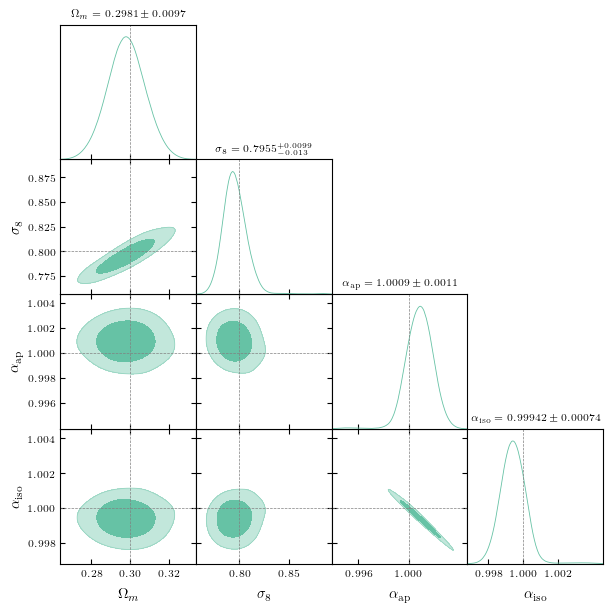

In [ ]:
gdsamp = chains[names[:-1]].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=7)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,
                contour_colors=[SetDark2(0)],)

## Example 2: quantify MCMC performance

### Number of eval per effective sample should converge. If so, that's a relevant metric.

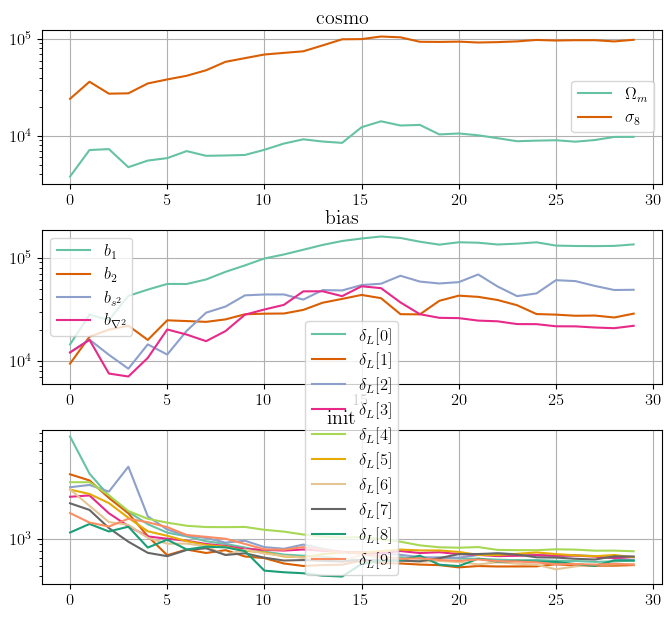

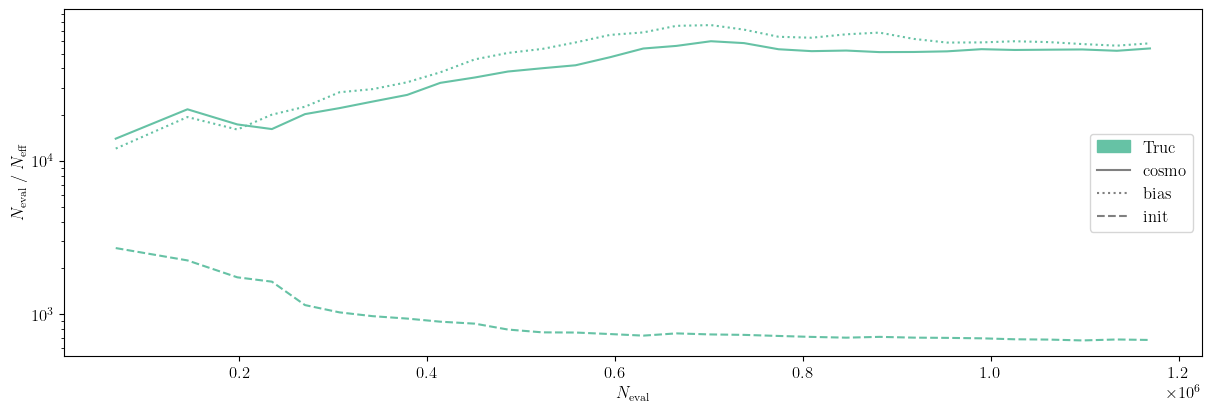

In [ ]:
plt.figure(figsize=(8, 6))
chains[['*~kptc']].flatten().cumtrans(Chains.eval_per_ess, 30).plot(names, 1, log=True)

labels = ['Truc']
metrics = []
cumess = chains[['*~kptc']].stackby(names).cumtrans(Chains.eval_per_ess, 30)
metrics.append(cumess)

def plot_fn(metrics, labels):
    plt.figure(figsize=(12, 4), layout="constrained")
    i_start = 0
    styles = ['-', ':', '--']
    for i_m, (metric, meth) in enumerate(zip(metrics, labels)):
        for i_g, (st, g) in enumerate(zip(styles, names)):
            plt.semilogy(metric['n_evals'][i_start:], metric[g][i_start:], st, c=SetDark2(i_m), label=g)

    from matplotlib.lines import Line2D; from matplotlib.patches import Patch
    handles = []
    for i_m, method in enumerate(labels):
        handles.append(Patch(color=SetDark2(i_m), label=method))
    for i_g, g in enumerate(names):
        handles.append(Line2D([], [], color='grey', linestyle=styles[i_g], label=g))

    plt.legend(handles=handles);

plot_fn(metrics, labels)
plt.xlabel("$N_{\\mathrm{eval}}$")
plt.ylabel("$N_{\\mathrm{eval}}\\;/\\;N_{\\mathrm{eff}}$");

## Comparison

2025-05-19 14:42:07.421389: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Loading: test, from run 2 to run 15 (included)
{'Omega_m': (4, 1792), 'b1': (4, 1792), 'b2': (4, 1792), 'bn2': (4, 1792), 'bs2': (4, 1792), 'fNL': (4, 1792), 'init_mesh': (4, 1792, 10), 'kptc': ((4, 1792, 12), (4, 1792, 12), (4, 1792, 12), (4, 1792, 12)), 'logdensity': (4, 1792), 'mse_per_dim': (4, 1792), 'n_evals': (4, 1792), 'ngbar': (4, 1792), 'sigma8': (4, 1792)}

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
 init_mesh[0]     -0.10      0.12     -0.10     -0.29      0.10   3011.15      1.00
 init_mesh[1]     -0.02      0.30     -0.01     -0.52      0.48   1400.55      1.00
 init_mesh[2]      0.02      0.30      0.03     -0.47      0.49   1464.51      1.00
 init_mesh[3]      0.00      0.30     -0.00     -0.52      0.45   1442.23      1.00
 init_mesh[4]     -0.15      0.10     -0.15     -0.31      0.03   2340.74      1.00
 init_mesh[5]      0.06      0.04      0.06     -0.01      0.13   1948.21      1.00
 init_mesh[6]      0.15      0.04      0.

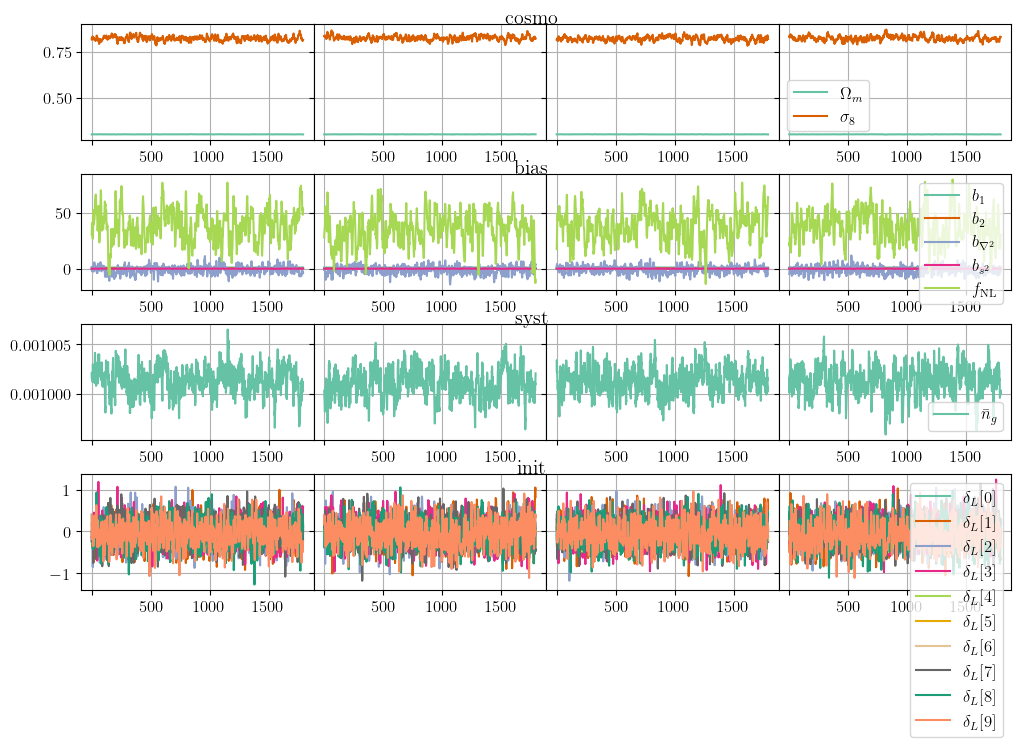

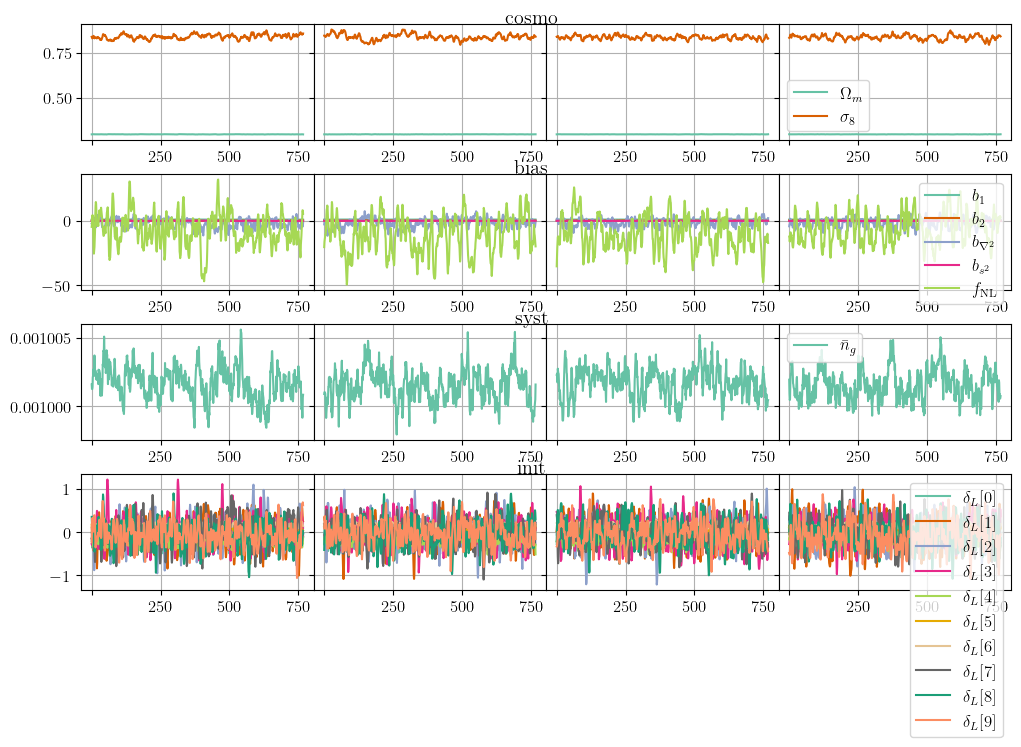

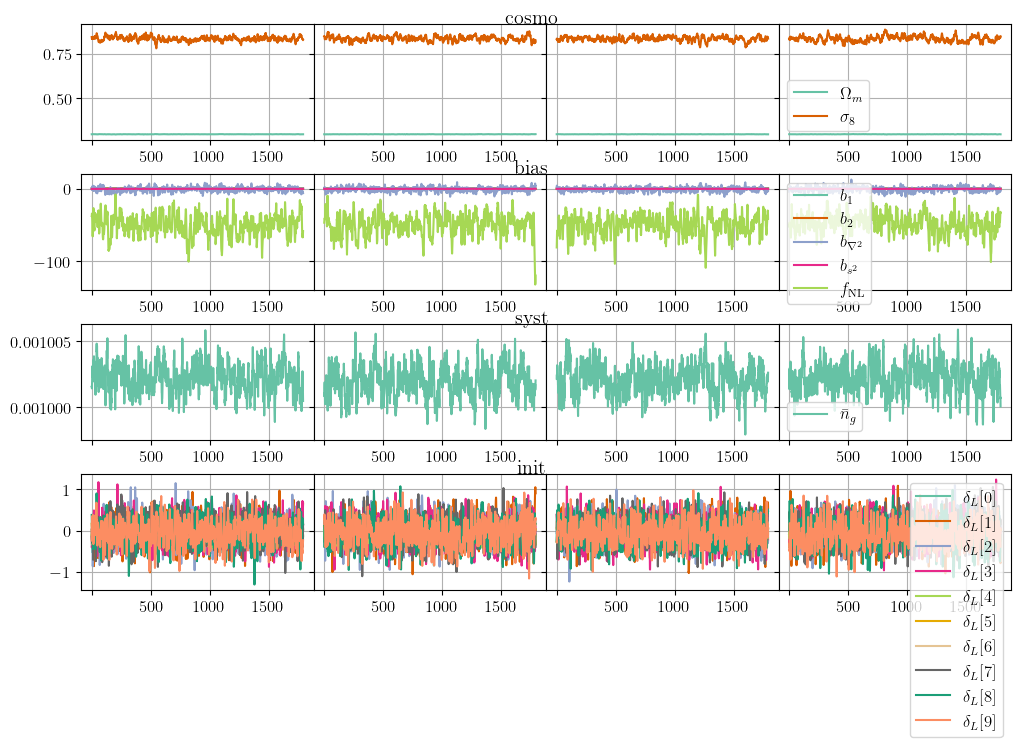

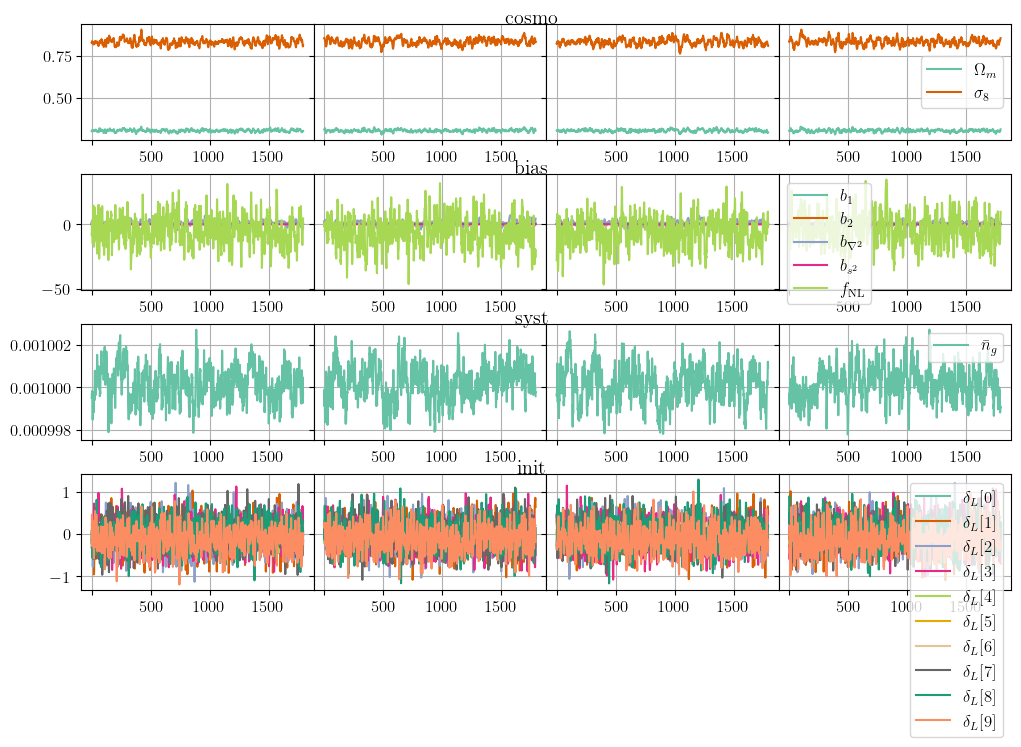

In [3]:
from montecosmo.chains import Chains
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh, theme, SetDark2
theme(usetex=True, font_size=12)

ids = np.array([0,1,2,3])
save_dir = Path("/feynman/home/dphp/hs276503/scratch/png")
save_dirs = np.array([save_dir / s for s in ["lpt_64_fnl_p50", "lpt_64_fnl_0", "lpt_64_fnl_m50", "lpt_fnl_64_kaiser_stat"]])[ids]
save_paths = np.array([save_dir / "test" for save_dir in save_dirs])
labels = np.array(['$f_\\mathrm{NL} = -50$', '$f_\\mathrm{NL} = 0$', '$f_\\mathrm{NL} = +50$', '$f_\\mathrm{NL} = 0$'])[ids]

gdsamps = []
kptcs = []
names = ['cosmo','bias','syst','init']
# names = ['cosmo_','bias_','syst_','init_']

for sd, sp, lab in zip(save_dirs, save_paths, labels):
    model = FieldLevelModel.load(sd / "model.yaml")

    truth = dict(jnp.load(sd / 'truth.npz'))
    mesh_true = jnp.fft.irfftn(truth['init_mesh'])
    kpow_true = model.spectrum(mesh_true)
    delta_obs = model.count2delta(truth['obs'])
    kptc_obs = model.powtranscoh(mesh_true, delta_obs)

    obs = ['obs','Omega_m','sigma8','b1','b2','bs2','bn2','fNL','ngbar','init_mesh']
    obs = {k: truth[k] for k in obs}
    model.condition(obs, from_base=True)

    transforms = [
                #   lambda x: x[:3],
                partial(Chains.thin, thinning=1),                     # thin the chains
                model.reparam_chains,                                 # reparametrize sample variables into base variables
                partial(model.powtranscoh_chains, mesh0=mesh_true),   # compute mesh statistics
                partial(Chains.choice, n=10, names=['init','init_']), # subsample mesh 
                ]
    chains = model.load_runs(sp, 2, 15, transforms=transforms, batch_ndim=2)
    print(chains.shape)

    plt.figure(figsize=(12,6))
    chains[['*~kptc']].flatten().plot(names)
    chains[['*~kptc']].print_summary()

    gdsamp = chains[names[:-1]].to_getdist(lab)
    gdsamps.append(gdsamp)

    kptc = tree.map(jnp.concatenate, chains.pop('kptc', None))
    kptcs.append(kptc)



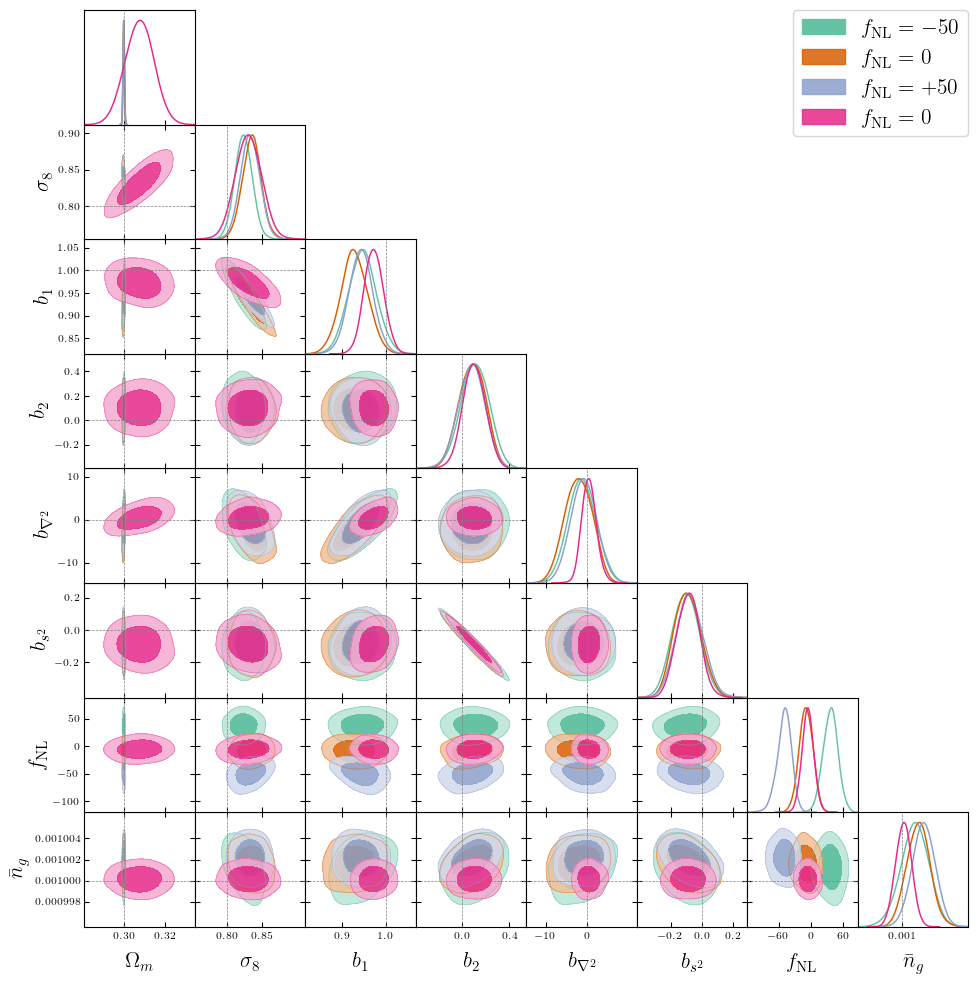

In [4]:
gdplt = plots.get_subplot_plotter(width_inch=10)
gdplt.settings.legend_fontsize = 20
gdplt.settings.axes_labelsize = 20
gdplt.settings.axes_fontsize = 12
gdplt.settings.figure_legend_frame = True
gdplt.settings.linewidth = 3
# gdplt.settings.num_plot_contours = 3
gdplt.triangle_plot(roots=gdsamps[:],
                # title_limit=1,
                filled=True, 
                markers={k:v for k,v in truth.items() if k not in ['fNL']},
                contour_colors=[SetDark2(i) for i in range(len(gdsamps))],
                legend_loc='upper right',
                )
# plt.savefig(save_dir / 'lpt_64_fnl_triangle.pdf', bbox_inches='tight')
plt.savefig(save_dir / 'lpt_64_fnl_triangle.webp', bbox_inches='tight')

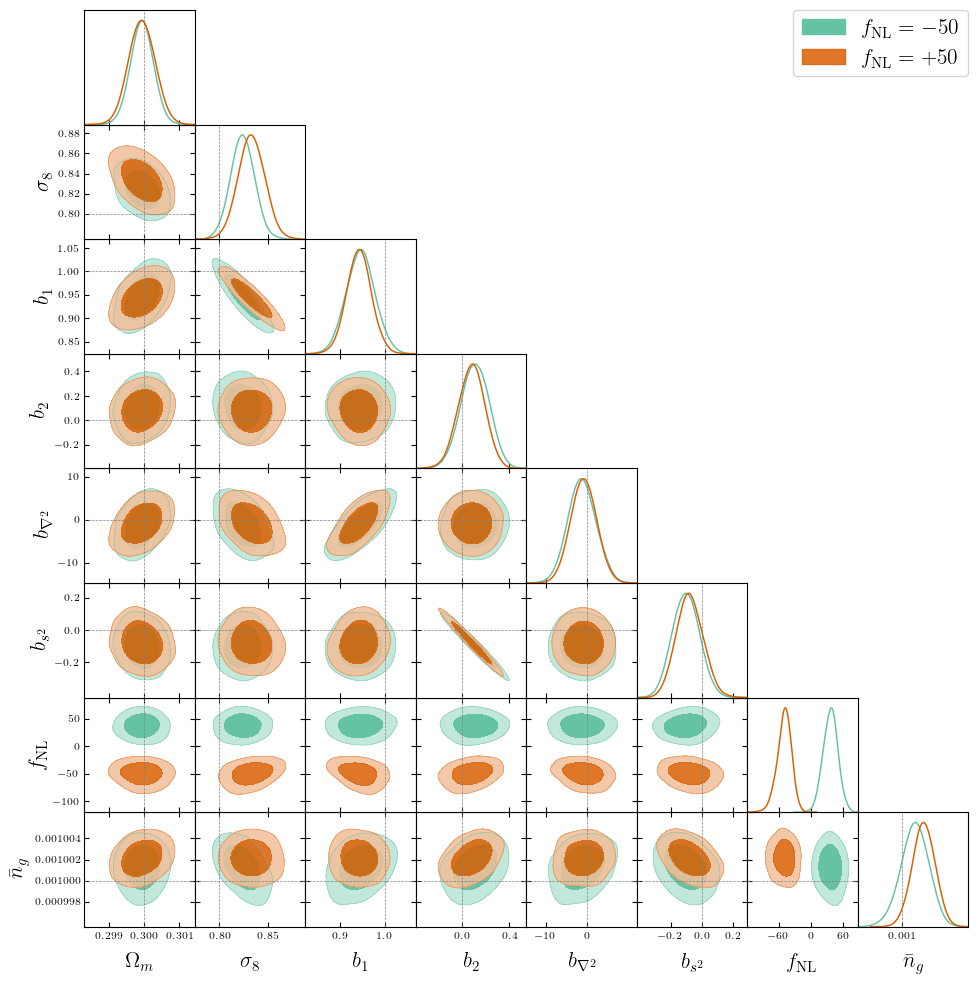

In [ ]:
gdplt = plots.get_subplot_plotter(width_inch=10)
gdplt.settings.legend_fontsize = 20
gdplt.settings.axes_labelsize = 20
gdplt.settings.axes_fontsize = 12
gdplt.settings.figure_legend_frame = True
gdplt.settings.linewidth = 3
# gdplt.settings.num_plot_contours = 3
gdplt.triangle_plot(roots=gdsamps[:],
                # title_limit=1,
                filled=True, 
                markers={k:v for k,v in truth.items() if k not in ['fNL']},
                contour_colors=[SetDark2(i) for i in range(len(gdsamps))],
                legend_loc='upper right',
                )
# plt.savefig(save_dir / 'lpt_64_fnl_triangle.pdf', bbox_inches='tight')
plt.savefig(save_dir / 'lpt_64_fnl_triangle.webp', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>